# Membuat Classifier nya

In [ ]:
# !pip install tensorflow
# !pip install pillow

In [1]:
import tensorflow as tf

In [2]:
# Define Input Parameters
dim = (160, 160)
# dim = (456, 456)
channel = (3, )
input_shape = dim + channel

#batch size
batch_size = 16

#Epoch
epoch = 10

# Membuat dataset generator

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mendefinisikan Data Generatornya

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

## Mendefinisikan asal folder sumber file berasal

In [5]:
# binary = [1,0,0,0,0] [0,1,0,0,0] [0,0,1,0,0] [0,0,0,1,0] [0,0,0,0,1]
# categorical = 1,2,3,4,5

train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()

Found 3453 images belonging to 5 classes.
Found 432 images belonging to 5 classes.
Found 432 images belonging to 5 classes.


In [6]:
print(labels)

dict_keys(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])


## Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

In [7]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [8]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

# Membuat Struktur CNN

## Manualy define network

In [9]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

In [10]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 128)     3584      
                                                                 
 activation (Activation)     (None, 160, 160, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 158, 158, 32)      36896     
                                                                 
 activation_1 (Activation)   (None, 158, 158, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 79, 79, 32)        0         
                                                        

## Using Pre-trained model / Transfer Learning

### Build Base Model (MobileNetV2)

In [12]:
from tensorflow.keras.applications import MobileNetV2

# get base models
base_model = MobileNetV2(
    input_shape= input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class,
)

### Add top layer network

In [13]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [14]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

In [15]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Effinet

In [ ]:
# !pip install -U --pre efficientnet

In [ ]:
from efficientnet.tfkeras import EfficientNetB1

### Build Base model

In [ ]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

### Add top network layer to models

In [ ]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [ ]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Visualize The final model

In [16]:
import tensorflow as tf

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

# Train Model

In [17]:
EPOCH = 2

In [18]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=EPOCH,
        validation_data=val_data,
        validation_steps=len(val_generator), 
        shuffle=True,
        verbose = 1)

Epoch 1/2
216/216 [==============================] - 164s 738ms/step - loss: 0.7961 - accuracy: 0.7359 - val_loss: 7.3778 - val_accuracy: 0.3472
Epoch 2/2
216/216 [==============================] - 140s 646ms/step - loss: 0.5758 - accuracy: 0.8083 - val_loss: 6.2847 - val_accuracy: 0.4398


In [19]:
history.history['loss']

[0.7961055040359497, 0.5758333206176758]

In [20]:
history.history['accuracy']

[0.7358818650245667, 0.8082826733589172]

# Plot the training

In [21]:
from matplotlib import pyplot as plt

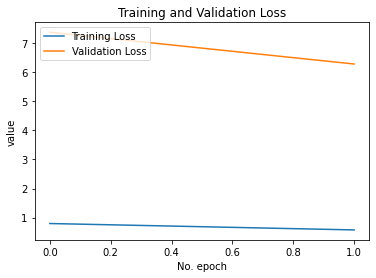

In [22]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

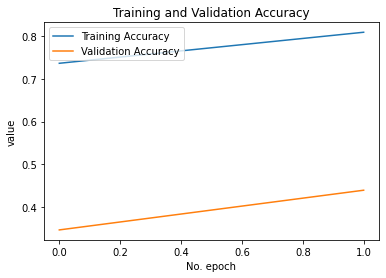

In [23]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Save Model

In [24]:
import os

In [26]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "model.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)    
    

Saving Model At model\medium_project\model.h5...


# Evaluate Models

In [28]:
loss, acc = model.evaluate(train_data, steps=len(train_generator), verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data, steps=len(test_generator), verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')    

Accuracy on training data: 0.4500 
Loss on training data: 6.3208 

Accuracy on test data: 0.4329 
Loss on test data: 6.3644 

